# $R_{\alpha}$: Measuring Robustness in Graphs

In this notebook I provide an implementation of $R_{\alpha}$ for directed graphs.

### What is $R_{\alpha}$
$R_{\alpha}$ quantifies the robustness of a graph, particularly useful to assess the stability of ecological networks, such as food webs. Formally, it reflects the relative amount of primary extinctions necessary for the network to reduce to $\alpha %$ of its original size. Secondary extinctions occur when species are left without any inward-edge. Hence, $R_{\alpha} \leq \alpha$. 

### Algorithm Analysis
A high level overview of the steps performed by the algorithm:

<div style="background-color:rgba(0, 0, 0, 0.05); padding:10px 0;font-family:monospace;">
while size > alpha * original size <br>
&nbsp;&nbsp;&nbsp;&nbsp; primary extinction = random node <br>
&nbsp;&nbsp;&nbsp;&nbsp; neighbors = neighbors of primary extinction <br>
&nbsp;&nbsp;&nbsp;&nbsp; remove primary extinction from graph <br>
&nbsp;&nbsp;&nbsp;&nbsp; while there are neighbors <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; if in-degree of neighbor == 0 <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; save neighbor of neighbors <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; remove neighbor from graph <br>
return current graph size / original graph size <br>
</div>

In the actual implementation the algorithm is more complex. The search for secondary extinctions is performed iteratively on the k-th distance-level-neighbors of the primary extinction, until all the necessary removals are performed. More details in the implementation.

In the worst case, the input graph is a complete directed graph, such that the running time of the algorithm is in $\mathcal{O}(n^3)$, where $n$ is the amount of nodes in the graph. The algorithm performs fairly well on graphs with lower connectance, because the search for secondary extinctions takes far less time in these graphs. The amount of k-level-neighbors to check after each removal is of $|K|^2$ in the worst case. Thanks to a "change flag" when iterating through the neighbors, if no new neighbor was removed, the loop breaks, and the next random removal can be performed.

### Notes
- Basal nodes can be removed, but are never part of a secondary extinction, because they're not successors of any specie.
- No rewiring of connections is performed.
- It is possible that the graph disconnets. This happens if a cycle gets isolated from the rest of the network. We assume isoltated cycle, which no longer receive energy from any basal nodes to be valid, and to not die out.
- Isolated self-loops are removed if created by removal. If the original graph already contains isolated self-loops, the algorithm will just not care about them.

### Resources:
- [Different attack strategies](https://www.sciencedirect.com/science/article/pii/S0304380012005789?via%3Dihub)
- [Habitat loss comparisons](https://onlinelibrary.wiley.com/doi/full/10.1111/ele.12117)
- [Correlation between robustness and connectance](https://www.sciencedirect.com/science/article/pii/S1470160X08000125)
- [Species loss and rewiring of trophic interactions](https://onlinelibrary.wiley.com/doi/full/10.1111/j.1461-0248.2010.01485.x)

In [1]:
import networkx as nx
import pandas as pd
import random
import time

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# $R_{\alpha}$: The Algorithm

In [5]:
def R_alpha(G, alpha=0.5, strategy='random', save_sub_graphs=False):

    # TODO: understand how R-alpha should be normalized exactly! because we want it to be from 0 to 1.
    # TODO: strategy='random', save_sub_graphs=False
    # TODO: compute cumulative secondary extinctions
    # TODO: analyse different worst cases and average case.

    """
    The function removes nodes randomly (primary extinctions) and computes consequent removals (secondary extinctions) until half of the nodes are removed.

    Parameters:
    G : NetworkX-DiGraph on which the R_alpha calculation is performed.
    alpha : reduction-percentage of the original size.

    Returns:
    r50 : The ratio of the number of primary extinction nodes to the initial size of the graph.
    sizes : List of the number of nodes in the graph after each removal operation.
    graphs : List of the states of the graph after each removal operation. Each entry is a NetworkX graph object.
    """

    if not 0 <= alpha <= 1:
        raise ValueError("`alpha` must be between 0 and 1")

    if G.number_of_nodes() == 0:
        raise ValueError("Input graph `G` is empty")

    print('Copying graph ...')
    start = time.time()
    graph = G.copy()  
    end = time.time()
    print(f'... finished copying after: {round(end - start, 5)} seconds.')

    original_size = graph.number_of_nodes()
    current_size = original_size
    
    print(f'current size: {current_size}')

    current_sizes = []
    current_sizes.append(original_size)

    random_removals = 0

    while current_size > alpha * original_size:

        random_removal = random.choice(list(graph.nodes))
        random_removals += 1

        print(f'random removal: {random_removal}')

        # Count the level of the secondary extinctions
        level_counter = 0

        # Save neighbors
        k_level_neighbors = set(graph.successors(random_removal))

        graph.remove_node(random_removal)

        # Explore neighbors level after level
        while len(k_level_neighbors) > 0:

            level_counter = level_counter + 1

            # print(f'neighborhood at level {level_counter}: {k_level_neighbors}')

            new_level_neighbors = set()
            removed_neighbors = set()

            # In the worst case the check must be done |k_level_neighbors| times
            for i in range(len(k_level_neighbors)):
                change_flag = False  # flag indicating if any nodes were removed in this loop

                for neighbor in set(k_level_neighbors):  # TODO: check scenario of copying set and without
                    
                    # print(f'visiting: {neighbor}')
                    
                    # A node is removed if it does not have any inward edge or if it's an isolated self-loop
                    if graph.in_degree(neighbor) == 0 or graph.degree(neighbor) == 0 or (graph.in_degree(neighbor) == 1 and graph.has_edge(neighbor, neighbor)):
                        new_level_neighbors.update(set(graph.successors(neighbor)))
                        k_level_neighbors.remove(neighbor)
                        removed_neighbors.add(neighbor)
                        graph.remove_node(neighbor)

                        change_flag = True
                        # print(f'removing node: {neighbor}')
                
                if not change_flag:
                    # if flag is still false, no nodes were removed, so break out of the loop
                    break

            k_level_neighbors = new_level_neighbors - removed_neighbors

        # Update current size of the graph after each random removal iteration
        current_size = graph.number_of_nodes()
        current_sizes.append(current_size)

        print(f'current size: {current_size}')

    r50 = random_removals / original_size
    # TODO: write documentation
    r50 = r50 / alpha
    return r50, current_sizes, graph

# $R_{50}$ on the Metaweb

In [3]:
def load_graph():
    csv_file = "../food_webs/03_metaweb_restrained_conservative.csv"
    edge_data_df = pd.read_csv(csv_file, low_memory=False)
    G = nx.from_pandas_edgelist(edge_data_df, source='Source_Name', target='Target_Name', edge_attr=True, create_using=nx.DiGraph())

    return nx.reverse(G)

G = load_graph()

In [6]:
print(f'Graph dimensions: \n Number of nodes: {len(G.nodes)} \n Number of edges: {len(G.edges)}')

Graph dimensions: 
 Number of nodes: 23193 
 Number of edges: 13186018


In [7]:
%%time

R50, sizes, r_alpha_graph = R_alpha(G)
print(f'R50: {R50}')

Copying graph ...
... finished copying after: 26.26136 seconds.
current size: 23193
random removal: Heliophanus patagiatus
current size: 23192
random removal: Coleophora antennariella
current size: 23191
random removal: Uroleucon ochropus
current size: 23190
random removal: Gymnetron rostellum
current size: 23189
random removal: Inula conyzae
current size: 23187
random removal: Hoplolabis idiophallus
current size: 23186
random removal: Orsodacne humeralis
current size: 23185
random removal: Halticus luteicollis
current size: 23184
random removal: Pseudonapomyza europaea
current size: 23183
random removal: Festuca lemanii
current size: 23182
random removal: Phalacronothus quadrimaculatus
current size: 23181
random removal: Potamogeton pusillus
current size: 23180
random removal: Veronica alpina
current size: 23179
random removal: Eublemma purpurina
current size: 23178
random removal: Exechiopsis subulata
current size: 23177
random removal: Anthocoris amplicollis
current size: 23176
rand

# Test: Isolated Self Loops on Metaweb

Test's the condition: "if graph.in_degree(neighbor) == 0 or (graph.in_degree(neighbor) == 1 and graph.has_edge(neighbor, neighbor))"
- Prooves that isolated self loops are removed if they're not already alone at the beginning.
- If they're already alone at the beginning, the graph is disconnected, and the graph is missing some important interaction (bad data).

In [55]:
initial_isolated_nodes_with_selfloops = {node for node in nx.nodes_with_selfloops(G) if G.in_degree(node) == 1 and G.out_degree(node) == 1}
final_isolated_nodes_with_selfloops = {node for node in nx.nodes_with_selfloops(r_alpha_graph) if G.in_degree(node) == 1 and G.out_degree(node) == 1}

if final_isolated_nodes_with_selfloops.issubset(initial_isolated_nodes_with_selfloops):
    print('The spotted nodes are alone already at the beginning.')
else:
    print('The algorithm does not do its job.')
    print(initial_isolated_nodes_with_selfloops)
    print(final_isolated_nodes_with_selfloops)

The spotted nodes are alone already at the beginning.


# Test: $R_{50}$ on Mock Graph

The mock graph is constructed in such way that all the algorithm's features are covered.

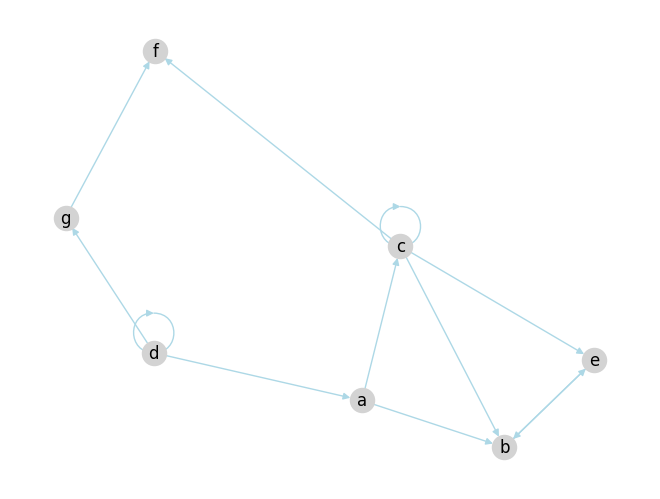

In [61]:
def load_test_graph():
    edges = [
        ('d', 'g'),
        ('d', 'a'),
        ('a', 'b'),
        ('a', 'c'),
        ('c', 'b'),
        ('b', 'e'),
        ('e', 'b'),
        ('c', 'e'),
        ('c', 'f'),
        ('g', 'f'),
        ('d', 'd'),
        ('c', 'c')
    ]
    G = nx.DiGraph()
    G.add_edges_from(edges)

    return G

G = load_test_graph()

position = nx.spring_layout(G, iterations=20, seed=1)
nx.draw(G, pos=position, node_color="lightgrey", edge_color="lightblue", with_labels=True)

In [67]:
%%time

R50, sizes, r_alpha_graph = R_alpha(G)
print(f'R50: {R50}')

Copying graph ...
... finished copying after: 4e-05 seconds.
current size: 7
random removal: e
neighborhood at level 1: {'b'}
visiting: b
current size: 6
random removal: a
neighborhood at level 1: {'c', 'b'}
visiting: c
removing node: c
visiting: b
removing node: b
neighborhood at level 2: {'f'}
visiting: f
current size: 3
R50: 0.2857142857142857
CPU times: user 181 µs, sys: 11 µs, total: 192 µs
Wall time: 183 µs
